This post is meant to show you how to apply Robust Tensor PCA in practice using [TensorLy](https://tensorly.github.io/). I'll provide a little bit of mathematical background on Robust PCA, feel free to skip that parts if Math is not your cup of tea. Otherwise, grab some biscuits. Then I'll demonstrate how to easily apply Robust Tensor PCA on images using TensorLy.

# A short introduction to robust PCA 

This section is here to give a little bit of background on Robust PCA: you *do not* need this for the rest of the article, only read if you are interested!

In short, Robust PCA is analogous to traditional PCA but instead of recovering a low rank approximation of the matrix under some Gaussian noise assumption, it decomposes it as the sum of of a low rank matrix and a sparse one. Tensor Robust PCA further generalises this notion to tensors.

Let's start with traditional Principal Component Analysis. There are several ways to formulate the PCA problem, here we show the minimum reconstruction error formulation. Formally, we want to minimise the Frobenius norm of the reconstruction error under orthogonality constraint over the projection weights. Let $X \in \mathbb{R}^{M, N}$ be an $N$ by $M$ matrix. We want to find the orthonormal projection matrix $W \in \mathbb{R}^{M, K}, K \leq M$ that solves:

\begin{equation*}
\begin{aligned}
   & \min_{W} 
   & & \|X - XWW^T \|_F^2\\
   & \text{subject to} 
   & & W^TW = Id\\
\end{aligned}
\end{equation*}

If we write $D$ the reconstructed matrix $D = XWW^T$, we can equivalently write the problem as:

\begin{equation*}
\begin{aligned}
   & \min_{W} 
   & & \|X - D\|_F^2\\
   & \text{subject to} 
   & & rank(D) \leq K\\
\end{aligned}
\end{equation*}


Robust PCA still wants to minimise the error but this time under the asumption that the noise is gross but sparse: instead of minimising an $\ell_2$ norm, we minimise an $\ell_0$ norm of the reconstruction error. In addition, instead of setting an upper bound on the rank of the reconstruction,  we directly seek to minimze it:

\begin{equation*}
\begin{aligned}
   & \min_{D} 
   & & rank(D) +  \|X - D\|_0\\
\end{aligned}
\end{equation*}

However, this problem is NP-hard, which means it cannot be solved in Polynomial time (i.e. as the size of your data increases, the time it takes to solve it increases exponentially).

A nice way around this is to relax the problem using the convex surrogate of the norm $\ell_0$ and of the rank operator as proposed by Cantes in his paper "Robust Principal Component Analysis" in ACM Journal, 2011.

This turns the problem into a tractable one:

\begin{equation*}
\begin{aligned}
   & \min_{\tilde D} 
   & & \|D\|_* + \lambda \|X - D\|_1 \\
\end{aligned}
\end{equation*}

Note that I have cheekily added a regularisation parameter on the norm $\ell_1$ of the error while you weren't looking: in practice, this parameter controls how sparse the error matrix will be and needs to be tuned to each particular data.

Robust Tensor PCA generalises this problem to tensors. Instead of minimizing the nuclear norm of the data tensor $\tilde{X}$, we minimise the nuclear norm of its unfoldings, $\tilde{X_{[i]}}$ along each mode $i, i \in \left[1, \cdots, N\right].$

In other words, the problem robust tensor PCA solves is:


\begin{equation*}
\begin{aligned}
   & \min_{\tilde D} 
   & & \sum_{i=1}^N  \|\tilde D_{[i]}\|_* + \lambda \|\tilde X - \tilde D\|_1 \\
\end{aligned}
\end{equation*}


This is implemented in TensorLy using the Alternating Direction Method of Multipliers (ADMM) and wraped in a nice API.

# Example on the YaleB dataset

Here we will apply Robust Tensor PCA on the [YaleB dataset](http://vision.ucsd.edu/~leekc/ExtYaleDatabase/Yale%20Face%20Database.htm). It consists images of the faces of several people taken from the same angle but with different illumniations. We will use the cropped version where the images have been cropped to contain only the faces.

## Getting the data

I wrote a convenience function to download the data if it hasn't been done already and load it into a dictionary you can easily use:

In [1]:
from pathlib import Path
from urllib.request import urlretrieve
import zipfile
from scipy.misc import imread
from scipy.ndimage.interpolation import zoom#
import numpy as np


def fetch_cropped_yaleb(data_folder, zooming=0.5, max_n_subjects=None):
    """Returns a dictionary of paths
    
    Parameters
    ----------
    data_folder: string
    zooming: float, optional, default is 0.5
        factor by which to resize the images
    max_n_subjects: {None, int}, optional, default is None
        if not None, only the first max_n_subjects are returned
    
    Returns
    -------
    dict: {
        subjects_1: {'images': [image_1, ... image_N],
               'ambient': image_ambient,
        }
    }
    
    images are stored as numpy arrays
    """
    url = 'http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip'
    yaleb_path = Path(data_folder).joinpath('cropped_yaleb')
    
    if not yaleb_path.joinpath('CroppedYale').exists():
        yaleb_path.mkdir(parents=True)
    
    # If not already unzip, do it
    if not list(yaleb_path.iterdir()):
        zip_path = yaleb_path.joinpath('yaleb.zip')
        
        # If zip not already downloaded, download it
        if not zip_path.exists():
            urlretrieve(url, zip_path.as_posix())
        
        zfile = zipfile.ZipFile(zip_path.as_posix())
        zfile.extractall(path=yaleb_path.as_posix())

    yaleb = {}
    for folder_path in yaleb_path.joinpath('CroppedYale').iterdir():
        if max_n_subjects is not None and len(yaleb) > max_n_subjects:
            return yaleb
        
        if not folder_path.is_dir():
            continue
            
        video_name = folder_path.name
        paths = sorted(list(folder_path.glob('*.pgm')))
        images = []
        for path in paths:
            if 'Ambient' in path.name:
                ambient = imread(path.as_posix())
            else:
                images.append(zoom(imread(path.as_posix()), zooming)[None, ...])
                
        data = {'images':np.concatenate(images),
        'ambient':ambient}
        yaleb[video_name] = data

    return yaleb

All you need is define where you want to save the data on your disk and the function will download and unzip it for you:

In [ ]:
dataset_path = '/data/tensorly_data/'

data = fetch_cropped_yaleb(dataset_path, zooming=0.3, max_n_subjects=5)

## Create the data tensor 

First we accumulate all the data into a tensor: each image is in grayscale and represented as a 2-dimensional numpy array of shape (height, width). We will stack them in a tensor of size (n_images, height, width):

In [3]:
X = np.concatenate([data[key]['images'] for key in data], axis=0)

print(X.shape)

(384, 58, 50)


Optionally, one might want to normalise the values of the images (they are currently uint8 ranging from 0 to 255) so let's convert them into float64:

In [4]:
X = X.astype(np.float64)
X -= X.mean()

## Visualise the data 

Let's define a simple helper function to visualise the images:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualise_images(X, n_images, n_columns, randomise=True):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]
    cmap = plt.cm.Greys_r
    n_rows = np.ceil(n_images / n_columns)
    fig = plt.figure(figsize=(2*n_columns, 2*n_rows))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        ax = fig.add_subplot(n_rows, n_columns, i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')

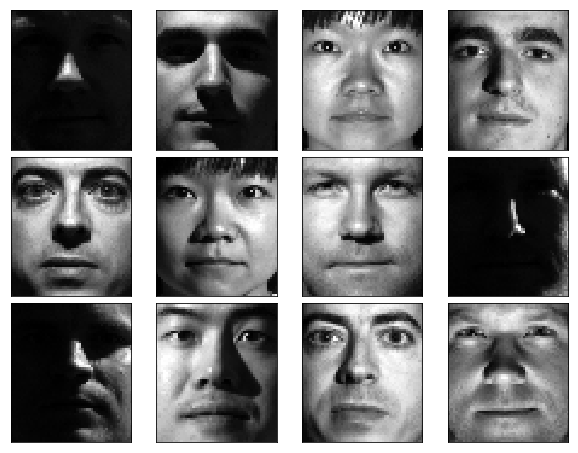

In [6]:
visualise_images(X, 12, 4)

## Add salt and pepper noise

To test the Robust PCA and its ability to recover the low rank structure under gross, sparse error, we will add some noise to the images using TensorLy's function `add_noise`:

In [7]:
from tensorly.random.noise import add_noise
from tensorly.random import check_random_state

random_state = 1234

Note that we define a random_state to fix the seed of the random generator and allow for reproducible results. Feel free to change the state or remove this altogether.

In [8]:
X = add_noise(X, noise='salt_pepper', percent=0.15, inplace=True, random_state=random_state)

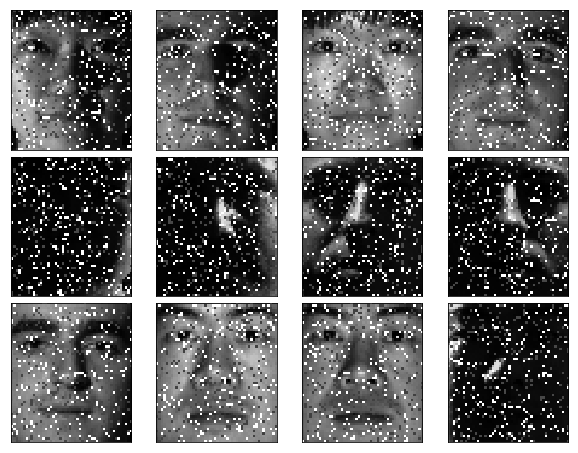

In [9]:
visualise_images(X, 12, 4)

## Apply Robust PCA 

Robust PCA decomposes the data tensor (X) into the sum of a low rank tensor (in this case, a denoised version) and a sparse tensor (the noise). In TensorLy, you can directly use the :function:`tensorly.decomposition.robust_pca` fuction.

In [10]:
from tensorly.decomposition import robust_pca

The robust_pca functions returns two tensors with identical dimensions to the tensor decomposed: the low rank part and the sparse part:

In [11]:
low_rank_part, sparse_part = robust_pca(X, reg_E=0.04, learning_rate=1.2, n_iter_max=20)

You can check that both term are tensor with the same shape as X:

In [12]:
print('X.shape={} == low_rank_part.shape={} == sparse_part.shape={}.'.format(X.shape, low_rank_part.shape, sparse_part.shape))

X.shape=(384, 58, 50) == low_rank_part.shape=(384, 58, 50) == sparse_part.shape=(384, 58, 50).


## Visualise the result 

Again let's write a simple helper function to visualise the results of the Robust Tensor PCA:

In [13]:
def visualise_rpca(X, low_rank_part, sparse_part, n_images=10):
    """A little helper function to visualise the result of tensor RPCA
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    indices = indices[:n_images]

    fig = plt.figure(figsize=(10, 2*n_images))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # plot the digits: each image is 8x8 pixels
    for i, e in enumerate(indices):
        cmap = plt.cm.Greys_r

        ax = fig.add_subplot(n_images, 4, 4*i + 1, xticks=[], yticks=[])
        ax.imshow(X[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Original')

        ax = fig.add_subplot(n_images, 4, 4*i + 2, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Low-rank')

        ax = fig.add_subplot(n_images, 4, 4*i + 3, xticks=[], yticks=[])
        ax.imshow(sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Sparse')

        ax = fig.add_subplot(n_images, 4, 4*i + 4, xticks=[], yticks=[])
        ax.imshow(low_rank_part[e]+sparse_part[e], cmap=cmap, interpolation='nearest')
        if not i:
            ax.set_title('Reconstruction')


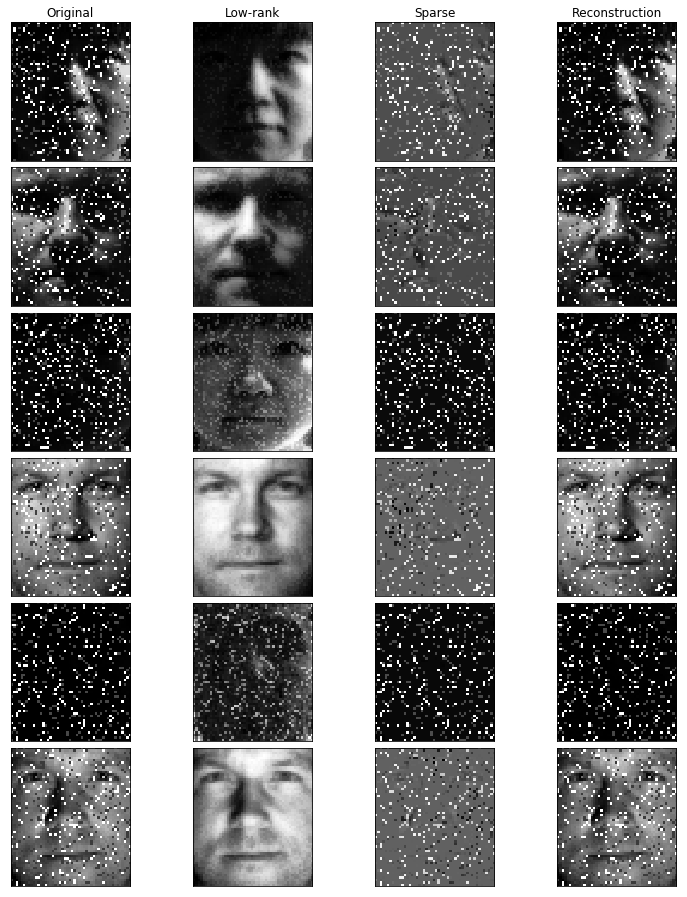

In [14]:
visualise_rpca(X, low_rank_part, sparse_part, n_images=6)

As you can see, the Robust PCA was able to isolate the clean tensor from the noise.

## Adding some missing values

Let's now add some missing values. We will replace the pixels in random patches of size 20 by 20:

In [15]:
from tensorly.random.noise import patch_noise

We will create a mask with the same shape as our data tensor which will have value one for pathces of size (20, 20) position randomly in each sample:

In [16]:
noise_mask = patch_noise(np.zeros(X.shape), (20, 20), noise=1, inplace=True, random_state=random_state).astype(bool)

Set the pixels inside the patches to zero:

In [17]:
X[noise_mask] = 0

Now, let's check the result:

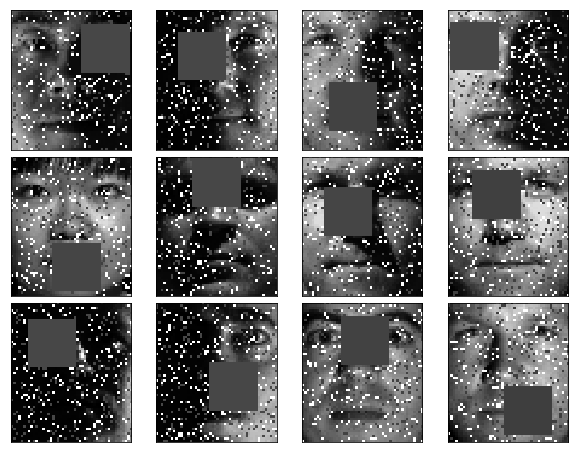

In [18]:
visualise_images(X, 12, 4)

The robust_pca function can take a mask as a parameter that is 0/False wherever the values are missing and 1/True everywhere else.

In [19]:
low_rank_part, sparse_part = robust_pca(X, mask=~noise_mask, reg_E=0.04, learning_rate=1.2, n_iter_max=20)

Let's visualise the results:

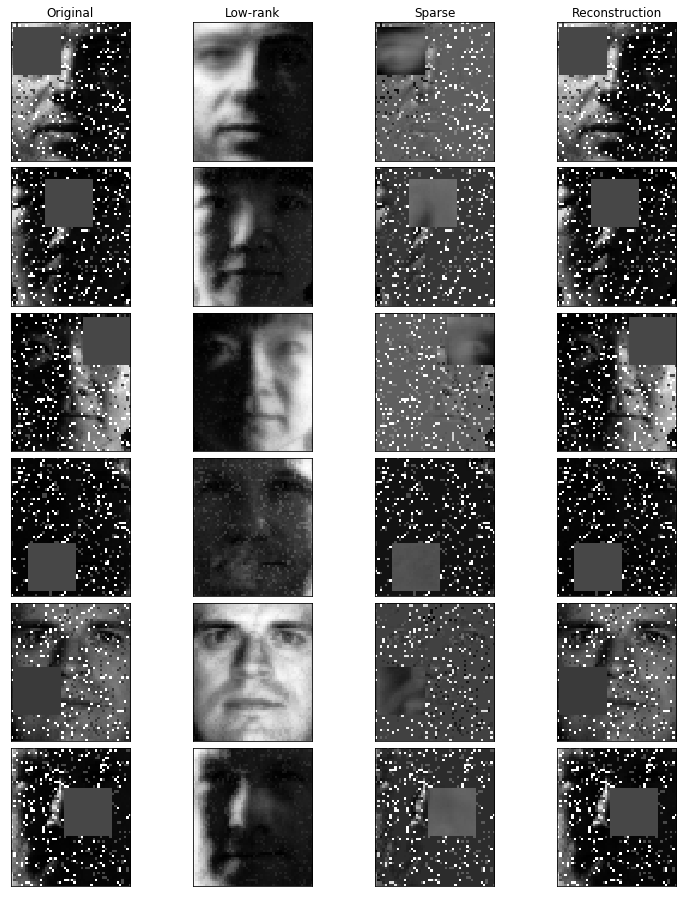

In [20]:
visualise_rpca(X, low_rank_part, sparse_part, n_images=6)

Once again the Robust Tensor PCA was able to isolate the gross error from the rest.

# Example on the Olivetti dataset

It seems that the website I had used to get the YaleB data is down, so as a backup data, we are going to use the Olivetti dataset. The excellent [scikit-learn](http://scikit-learn.org/dev/) has utility function to download various datasets, including the one we are interested in:

In [21]:
from sklearn.datasets import fetch_olivetti_faces

We are going to use directly the images instead of the vectorized version:

In [22]:
data = fetch_olivetti_faces()
# We directly use the images as our data tensor
X = data.images

X = X.astype(np.float64)
X -= X.mean()

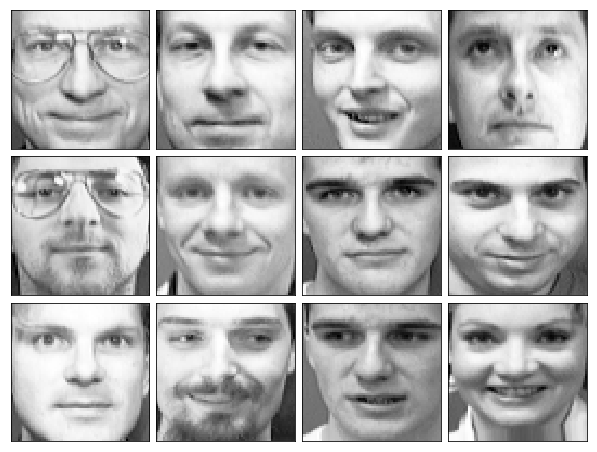

In [23]:
visualise_images(X, 12, 4)

As previously, we add some noise and missing values:

In [24]:
X = add_noise(X, noise='salt_pepper', percent=0.15, inplace=False, salt_value=1, pepper_value=1, random_state=random_state)
noise_mask = patch_noise(np.zeros(X.shape), (20, 20), noise=1, inplace=True, random_state=random_state).astype(bool)
X[noise_mask] = 0

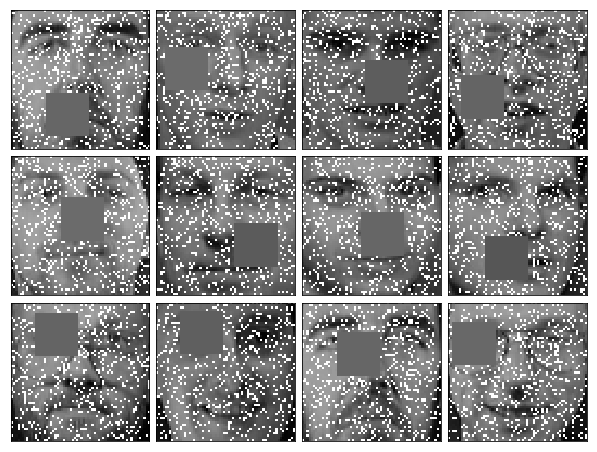

In [25]:
visualise_images(X, 12, 4)

Let's apply Robust PCA on this mess:

In [26]:
low_rank_part, sparse_part = robust_pca(X, mask=~noise_mask, reg_E=0.04, learning_rate=1.2, n_iter_max=50)

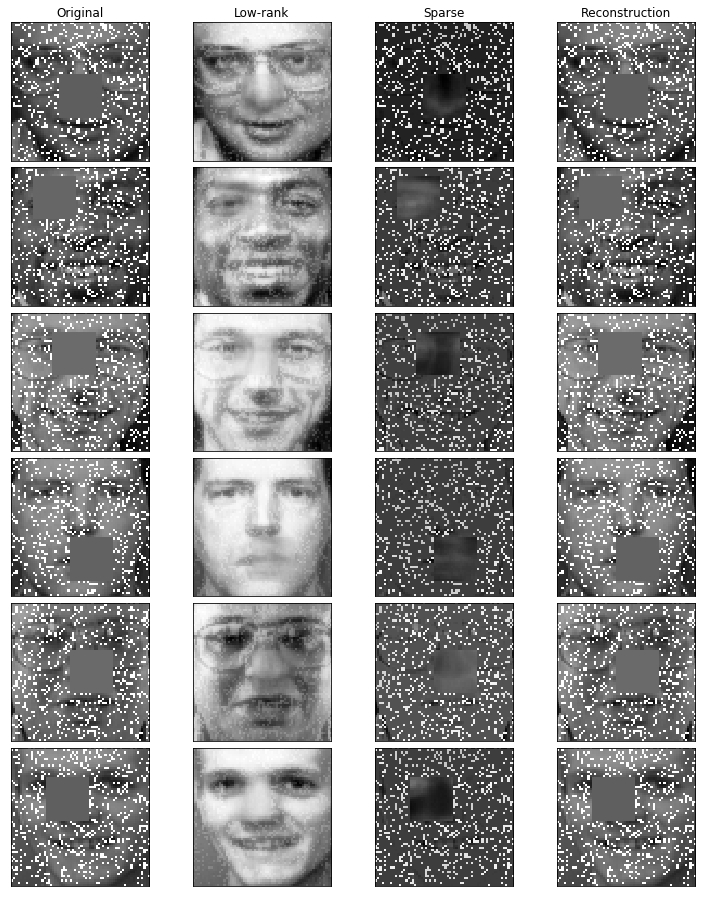

In [27]:
visualise_rpca(X, low_rank_part, sparse_part, n_images=6)

The result is decent, though we could probably enhance it a bit by tuning the regularization parameter.

# Example on a video

Finally, I will conclude this with an example on a video. For this part, I will use my lightweight package [iopy](https://github.com/JeanKossaifi/iopy) (because reading video should be easy...) that offers wraps ffmpeg to allows reading videos as a list of numpy arrays (under the hood it simply opens a pipe and streams the images directly to you):

In [28]:
from iopy.collection import ImageCollection
from scipy.misc import imresize

Let's download a video to apply the Robust PCA on:

In [29]:
from urllib.request import urlretrieve
video_filename = 'campus.avi'
urlretrieve ("http://cvrr.ucsd.edu/aton/shadow/data/campus_raw.AVI", video_filename)

('campus.avi', <http.client.HTTPMessage at 0x7f79ed8bf390>)

We will use iopy to load the video using the ImageCollection object. The result is a lazy list that only loads the images upon access.

In [30]:
collection = ImageCollection.from_video_filename(video_filename, image_to_gray=True, image_dtype=np.float)

In [31]:
collection

ImageCollection, collection of 1179 elements, cachine disabled..

We will resize the images so as to not explode our memory:

In [32]:
def resize(image):
    return imresize(image, 0.5)

In [33]:
X = collection.to_matrix(flatten_images=False, apply_fun=resize)

In [34]:
X.shape

(1179, 144, 176)

Let's try to find some interesting images:

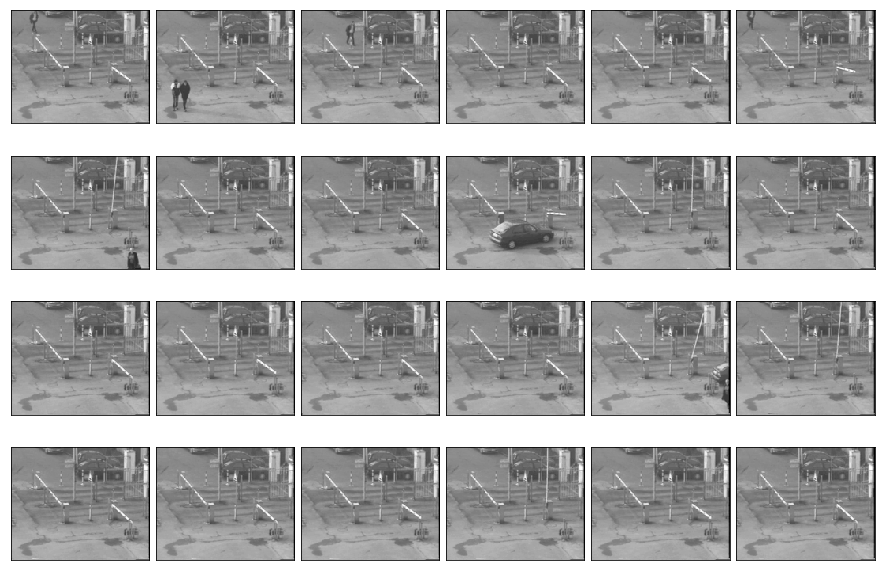

In [35]:
visualise_images(X, n_images=24, n_columns=6)

Now let's apply the Robust Tensor PCA. Warning: given the size of the tensor to decompose, if you try this at home, it might take a while depending on your computer.

In [36]:
low_rank_part, sparse_part = robust_pca(X, reg_E=0.01, learning_rate=1.2, n_iter_max=50)

Let's visualise the results (run it several times and you will see different frames since the `visualise_pca` function selects random ones to display):

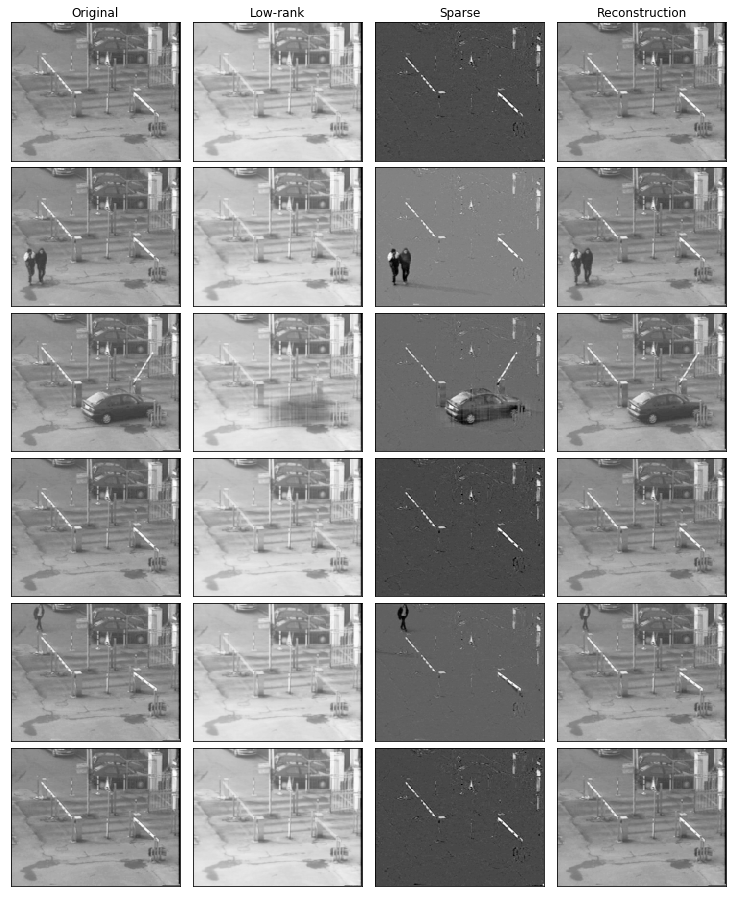

In [50]:
visualise_rpca(X, low_rank_part, sparse_part, n_images=6)

Just for your eyes pleasure, let's convert this into a video: iopy includes a function to stream numpy arrays back through ffmpeg to easily create videos:

In [38]:
from iopy.video import ffmpeg_image_list_to_video

As the algorithm returns floating numbers, we need to renormalise the results to be correct images before saving them (I should probably include this directly in the function saving the video).

In [39]:
def normalise(array):
    """Renormalise the array in the range [0, 255]
        
        Return an array of uint8 with 3 channels
    """
    if array.min() < 0 or array.max()>255:
        array = array - array.min()
        array /= array.max()
        array *= 255
    normalised = np.empty(list(array.shape) + [3])
    for i in range(3):
        normalised[..., i] = array
    return normalised.astype(np.uint8)

Here I simply create the concatenation of the original video, the low rank part and the sparse error side to side.

In [40]:
video_img = np.concatenate((normalise(X), normalise(low_rank_part), normalise(sparse_part)), axis=2)

To save the whole as a video you can simply to do:

In [41]:
ffmpeg_image_list_to_video('campus_RPCA.mp4', video_img, fps=10)

Creating the video:  [██████████████████████████████████████████████████] 100%  Processing frame 1179/1179Done.

Here, I will save a shorter version (the first 500 frames) for demo:

In [42]:
ffmpeg_image_list_to_video('campus_RPCA_short.mp4', video_img[:500, ...], fps=10)

Creating the video:  [██████████████████████████████████████████████████] 100%  Processing frame 500/500Done.

Let's now visualise the resulting video. First a convenience function to include the video in the notebook (I got the inspiration from https://kastnerkyle.github.io/posts/robust-matrix-decomposition/, a very interesting website by the way!)

In [52]:
import io
import base64
from IPython.display import HTML

def video_to_html(video_filename):
    """Function to embed a video in the web page
    
    Inspired from: 
    http://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook
    """
    ext = video_filename.split('.')[-1]
    video = io.open('campus_RPCA.mp4', 'rb').read()
    encoded = base64.b64encode(video)
    return HTML(data="<video alt='test' controls><source src='data:video/{1};base64,{0}' type='video/{1}' /></video>".format(encoded.decode('ascii'), ext))

And finally, the results!

In [54]:
video_to_html('campus_RPCA_short.mp4')

# Final words 

I want to thank my colleague [Christos Georgakis](https://ibug.doc.ic.ac.uk/people/cgeorgakis) for the productive discussions on Robust PCA. If you are interested in the subject you might want to read his latest [IJCV paper](https://ibug.doc.ic.ac.uk/media/uploads/documents/georgakis_ijcv.pdf) on Dynamic Behavior Analysis via Structured Rank Minimization.

Going forward, I am planning to adapt this as an example for TensorLy and add some more documentation. There are several possible improvements to the Tensor Robust PCA, starting with adding a term to gather the gaussian noise separately.